# Simulate a dataset

Here we are generating a dataset of odd-one-out choices for a set of geometric objects. The ground truth raters are basing their choices either more on color features (hue, brightness) or on shape features (rounding, size)

In [26]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

from triplets.models import RaterModelTriplet
from func import simulate_triplet_dataset, plot_triplet_row, string_figure

torch.manual_seed(1)
np.random.seed(1)

In [27]:
df_items = pd.read_csv('data/toy_simulation_items.csv',index_col=0)
df_raters = pd.read_csv('data/toy_simulation_raters.csv',index_col=0)
columns_gt = ['hue','brightness','rounding','size']

print(f'{df_items.shape[0]} items, {df_raters.shape[0]} raters')
print(f'Ground truth features: {", ".join(columns_gt)}')

48 items, 2 raters
Ground truth features: hue, brightness, rounding, size


To set up a ground truth rater model, we are initializing the pytorch model ```RaterModelTriplet```, which is the same that we use for model fitting. Here, we are setting the parameters ourself.

In [28]:
model_args = dict(
    dim_items=df_items.shape[0],
    dim_raters=df_raters.shape[0],
    num_dims=4,
    lambda_item=.1, lambda_rater=.1,
    distance='dotproduct',
    force_positive='softplus',
    fit_items=True, fit_raters=True,
    fit_sequence=True,
    reg_type=1, state_dict_path='model_state.pth'
)

model_gt = RaterModelTriplet(**model_args)
print(model_gt)

RaterModelTriplet(
  (linear_item): Linear(in_features=48, out_features=4, bias=False)
  (linear_rater): Linear(in_features=2, out_features=4, bias=False)
  (linear_sequence): Linear(in_features=2, out_features=1, bias=False)
)


First we fill the item parameters of the model with the (normalized) values for hue, brightness, rounding and size of the different items.

In [29]:
def normalize(column):
    column = column.copy()
    column -= column.mean()
    column /= column.std()
    return column

print(f'Items (5 of {df_items.shape[0]}):')
print('')
print(df_items[columns_gt].iloc[:5])
for ii, feature in enumerate(columns_gt):
    model_gt.linear_item.weight.data[ii] = torch.Tensor(normalize(df_items[feature]).values*3)

Items (5 of 48):

        hue  brightness  rounding       size
0  0.563481    0.852900  9.433439  17.440756
1  0.622513    0.859879  6.855568  16.399181
2  0.566410    0.451376  6.250356  17.927869
3  0.673569    0.447997  8.544441  13.892061
4  0.572167    0.594784  6.521228  12.234999


The following is an illustration of the geometric objects described by these features:

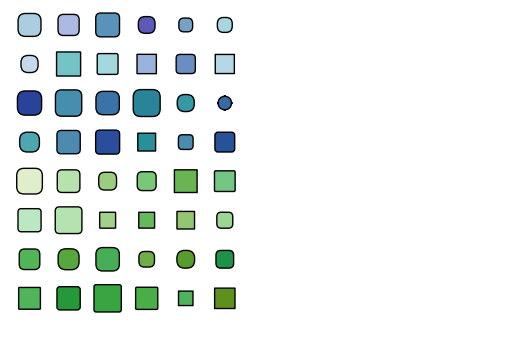

In [30]:
fig = plt.figure(1)
string_figure(fig, df_items, columns_gt)

Now we fill the rater parameters of the model to specify how the two raters should weigh the different features.

In [31]:
print('Raters:')
print('')
print(df_raters[columns_gt])
model_gt.linear_rater.weight.data = torch.Tensor(
    df_raters[columns_gt].values.T
)

Raters:

   hue  brightness  rounding  size
0    3         0.5        -1  -1.0
1   -1        -1.0         3   0.5


Now we simulate a dataset of odd-one-out choices:

In [32]:
df_triplets = simulate_triplet_dataset(
    model_gt, df_items, df_raters, 
    num_trials=64, items_per_trial=5
)

We show an example simulated trial where the two raters diverge in their choices

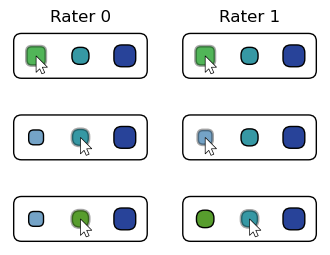

In [33]:
df_trial = df_triplets.query('trial_index==25')

fig = plt.figure(2)
axs = fig.subplots(3,2)
for triplet, ax_row in enumerate(axs):
    for rater, ax in enumerate(ax_row):
        plot_triplet_row(
            ax, df_trial.query(f'rater=={rater}').iloc[triplet], 
            df_items, mouse=True
        )
        if triplet==0:
            ax.set_title(f'Rater {rater}')
fig.set_size_inches([4,3])

The results of the odd-one-out task are saved in a dataframe of the following format:

In [34]:
df_trial

,stim_0,stim_1,stim_2,trial_index,rater,last_selected,selected,i_triplet
75,36,16,12,25,0,3,0,0
76,4,16,12,25,0,0,1,1
77,4,40,12,25,0,1,1,2
267,36,16,12,25,1,1,0,0
268,4,16,12,25,1,0,0,1
269,40,16,12,25,1,0,1,2


Each triplet choice in an experiment is described by one row.

- The first three columns (``stim_0,stim_1,stim_2``) contain the indices to the items of the current triplet choice
- ``trial_index`` indexes the triplet choices within a trial
- ``rater`` contains the index to the rater performing the current triplet choice
- ``selected`` contains the position (0, 1, or 2) of the item that was selected as the odd-one-out
- ``last_selected`` contains the position of the item that was previously selected. This value is set to ``3`` if it is the first triplet choice within a trial
- ``i_triplet`` specifies the order of the triplet choices within a trial

We save the simulated dataset for fitting models in the next step:

In [35]:
df_triplets.to_csv('data/toy_simulation_triplets.csv')